**Author**: Edoardo Gabrielli

**Date**: 21/04/2021

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Package-Import" data-toc-modified-id="Package-Import-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Package Import</a></span></li><li><span><a href="#For-a-time-series-clustering-how-can-I-know-that-I'm-plotting-the-correct-centroids?" data-toc-modified-id="For-a-time-series-clustering-how-can-I-know-that-I'm-plotting-the-correct-centroids?-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>For a time series clustering how can I know that I'm plotting the correct centroids?</a></span><ul class="toc-item"><li><span><a href="#Example-from-the-DM2-Notebook" data-toc-modified-id="Example-from-the-DM2-Notebook-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Example from the DM2 Notebook</a></span></li></ul></li><li><span><a href="#Building-The-Toy-Dataset" data-toc-modified-id="Building-The-Toy-Dataset-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Building The Toy Dataset</a></span><ul class="toc-item"><li><span><a href="#Function-for-the-Task" data-toc-modified-id="Function-for-the-Task-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Function for the Task</a></span></li><li><span><a href="#Examples" data-toc-modified-id="Examples-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Examples</a></span><ul class="toc-item"><li><span><a href="#The-output-data" data-toc-modified-id="The-output-data-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>The output data</a></span></li><li><span><a href="#Basic-Example" data-toc-modified-id="Basic-Example-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Basic Example</a></span></li><li><span><a href="#Example-with-random-perturbation" data-toc-modified-id="Example-with-random-perturbation-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Example with random perturbation</a></span></li></ul></li></ul></li><li><span><a href="#A-technical-Note" data-toc-modified-id="A-technical-Note-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>A technical Note</a></span></li><li><span><a href="#Clustering" data-toc-modified-id="Clustering-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Clustering</a></span><ul class="toc-item"><li><span><a href="#Kmeans" data-toc-modified-id="Kmeans-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Kmeans</a></span><ul class="toc-item"><li><span><a href="#Centroids" data-toc-modified-id="Centroids-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>Centroids</a></span></li><li><span><a href="#Medoids" data-toc-modified-id="Medoids-5.1.2"><span class="toc-item-num">5.1.2&nbsp;&nbsp;</span>Medoids</a></span></li></ul></li></ul></li></ul></div>

## Package Import

In [104]:
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, pandas as pd, IPython.display as ipd

# Preprocessing 
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# Import an external package ############################################################
import sys
import importlib # Eventualy eload the modules.
sys.path.insert(0,'.') # Load Current path as PYTHONPATH
import Time_Series_functions # Import my module
tts = Time_Series_functions.Toy_Time_Series # Shorter name for the function...
# If you don't like to import please just copy and paste the function in the notebook...
#########################################################################################

# Euclidean
from scipy.spatial.distance import euclidean

# Dynamic Time Warping
from tslearn.metrics import dtw, dtw_path, cdist_dtw, subsequence_cost_matrix
from pyts.metrics import dtw as dtw2

# Approximation of time series
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation
from tslearn.piecewise import OneD_SymbolicAggregateApproximation

# Time Series Clustering
from tslearn.clustering import TimeSeriesKMeans # Vantaggio che funziona con dtw

# Random walk of tslearn
from tslearn.generators import random_walks

In [105]:
# How to modify an imported module without restarting kernel:
importlib.reload(Time_Series_functions)

<module 'Time_Series_functions' from './Time_Series_functions.py'>

## For a time series clustering how can I know that I'm plotting the correct centroids?

The purpose of this notebook is to understand how class tslearn.clustering elaborate the data in order to visualize the correct centroids/medoids (curves) after the clustering process.

### Example from the DM2 Notebook

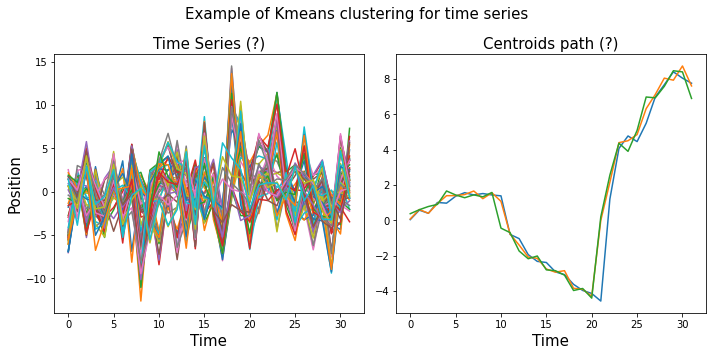

In [116]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
X = random_walks(n_ts=50, sz=32, d=1)
# Plot the random Walk
axs[0].plot(X.reshape(X.shape[1], X.shape[0]))
km = TimeSeriesKMeans(n_clusters=3, metric="euclidean", max_iter=5, random_state=0)
km.fit(X)
# Plot The centroids
axs[1].plot(km.cluster_centers_.reshape(X.shape[1], 3))
plt.suptitle('Example of Kmeans clustering for time series', fontsize=15)
[axs[i].set_title(j, fontsize=15) for i, j in enumerate(['Time Series (?)','Centroids path (?)'])]
[axs[i].set_xlabel('Time', fontsize=15) for i in range(2)]
axs[0].set_ylabel('Position', fontsize=15)
plt.tight_layout()
plt.show()

<img style="float: right;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/da/Random_Walk_example.svg/1200px-Random_Walk_example.svg.png" width="400" height="200">

**In this plot there are 2 strange fact:**

1. The random walk doesn't seem a random walk.
2. The centroid series are almost superimposed.
3. The centroids Series don't seem to represent anyone of the initial curve. 

---

For both of these problem there are two possible cause:

- The random walk given by tslearn is not working properly.
- Something goes wrong with the way of plotting.

---

Notice that for the third problem it is possible that the fault is of the definition of centroids (that is different by the definition of medoids)... We will analize this fact too.

**How To Solve**

- Build a toy dataset of time series (with well separated clusters).
- Apply the clustering algorithm.
- Plot the Data/the cluster centroids.

## Building The Toy Dataset

In this block I build the toy dataset using a function imported: tts (Toy_Time_Series)

### Function for the Task

In [10]:
help(tts)

Help on function Toy_Time_Series in module Time_Series_functions:

Toy_Time_Series(ff, time, n_series_for_cluster=10, n_cluster=3, random_state=None, r_ampl=None, r_off=None, iterargs=None, **kwargs)
     --------------------------
    |
    | Author: Edoardo Gabrielli
    |
     --------------------------
    |
    | DESCRIPTION:
    | Function that build a toy model for a time series clustering problem.
    |
     --------------------------
    |
    | INPUT PARAMETERS:
    | - ff: func
    |   The function that rules the toy model. This function need one argument:
    |      1) x: numpy nd-array, shape: (n_series_for_cluster, time) 
    |         This represent the array that will be filled with the function (for one single cluster)
    |      Optional:
    |      2) **kwargs (anything you want) other parameters that you need for the model 
    |      Example: 
    |      def ff(x, q = 0, phi=0):
    |          return np.sin(x + phi) + q       
    |         
    | - time: numpy 1d 

### Examples

#### The output data

Here an example of the output data structure in a pandas dataframe.

In [30]:
def parabola(x): # Naive function that return the number at power of 2.
    return x**2
xx = np.linspace(0, 9, 10) # time vector
yy = tts(parabola, xx) # output data
Id_df = pd.DataFrame(data=yy, index=[f'ts {i}' for i in range(len(yy))]) # output data in a pd dataframe
ipd.display(Id_df.head(3)) # Display output

,0,1,2,3,4,5,6,7,8,9
ts 0,0.0,1.0,4.0,9.0,16.0,25.0,36.0,49.0,64.0,81.0
ts 1,0.0,1.0,4.0,9.0,16.0,25.0,36.0,49.0,64.0,81.0
ts 2,0.0,1.0,4.0,9.0,16.0,25.0,36.0,49.0,64.0,81.0


In this example all the cluster are identical, in order to built problem more complicate we can add parameters to the function like in the next example.

#### Basic Example

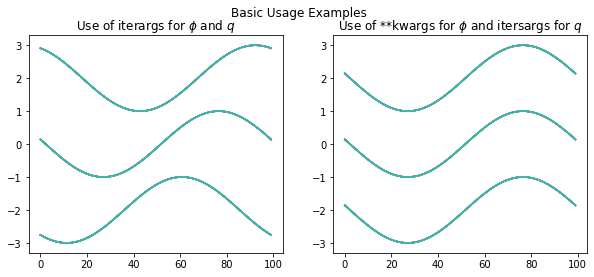

In [38]:
# Function for the series
def func(x, q = 0, phi = 0):
    return np.sin(x + phi) + q

# Parameters #############################################

n = 100                         # Lenght of time series (passed to xx below)
xx = np.linspace(0, 2*np.pi, n) # Building the time array
n_cluster = 3                   # Number of clusters
n_for_cluster = 10              # Number of time series for cluster

##########################################################

# Initialize Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Iterargs Procedure

iters = [dict(phi=i, q = j) for i, j in zip([2, 3, 4],[2, 0, -2])]
# the same of 
#         clust.1             clust.2             clust.3
#iters = [dict(phi=2, q = 2), dict(phi=3, q = 0), dict(phi=4, q = -2)]
yy1 = tts(func, xx, n_cluster = n_cluster, n_series_for_cluster = n_for_cluster, iterargs=iters)

# **kwargs + iterargs procedure

iters = [dict(q = i) for i in [2, 0, -2]]
yy2 = tts(func, xx, phi=3, iterargs=iters)

axs[0].plot(yy1.T)
axs[1].plot(yy2.T)
[axs[i].set_title(s) for i, s in enumerate([r'Use of iterargs for $\phi$ and $q$', r'Use of **kwargs for $\phi$ and itersargs for $q$'])]
plt.suptitle('Basic Usage Examples')
plt.show()

#### Example with random perturbation

Text(0.5, 0.98, 'Usage Example with random perturbation')

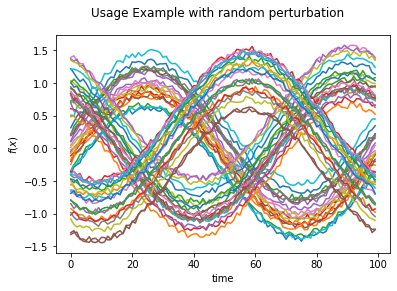

In [113]:
def phase_sin(x, phi = 0):
    return np.sin(x + phi)

# Parameters ###############################################
xx = np.linspace(0, 2*np.pi, 100) # Building the time array
n_cluster = 3                     # Number of clusters           | --> Total time series: 
n_series_for_cluster = 20         # Number of series for cluster | -->                   60
r_ampl = 0.1                     # Random amplitude superimposed to phase_sin
r_off = 0.5                       # Random amplitude of the offset on y axis for the different series.
pi = np.pi                        # Define pi value
iters = [dict(phi = 2*(pi/3)*i) for i in range(n_cluster)] # Different phase 
############################################################

yy = tts(phase_sin, xx, n_cluster = n_cluster, n_series_for_cluster = n_series_for_cluster, 
                     iterargs = iters, r_ampl = r_ampl, r_off = r_off )
plt.plot(yy.T)
plt.xlabel('time')
plt.ylabel(r'$f(x)$')
plt.suptitle('Usage Example with random perturbation')

## A technical Note

When you plot a time series like the previous one you pass to plt.plot the Transpose Dataset (yy.T). 

This is an abbreviation that allows to plot all the lines together insted of cicle on the singles time series. Let's prove this:

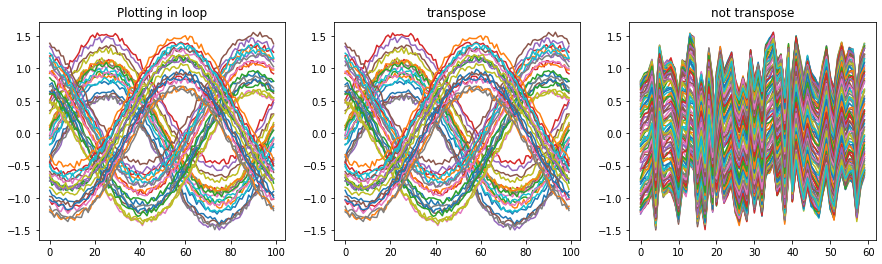

In [47]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
# Plot line by line
for y in yy:
    axs[0].plot(y)
# Plot transpose
axs[1].plot(yy.T)
# Plot not transpose
axs[2].plot(yy)

[axs[i].set_title(s) for i, s in enumerate(['Plotting in loop', 'transpose', 'not transpose'])]

plt.show()

Notice that in the last figure we can see why for time series we need to use the transpose command. 

In fact on the x label the plot indicate a maximum of 60: the number of row of our dataset.

In [14]:
print(f'For yy matrix (of data) we have: \nRow = {yy.shape[0]}\nColumns = {yy.shape[1]}')

For yy matrix (of data) we have: 
Row = 60
Columns = 100


So it is obvious that matplotlib always try to plot columns in function of row. 

In time series we need the opposite: the transposed of the data (yy).

## Clustering

### Kmeans

In [95]:
X = yy # Just to simplify
km = TimeSeriesKMeans(n_clusters=n_cluster, metric="euclidean", max_iter=5, random_state=0)
km.fit(X)

TimeSeriesKMeans(max_iter=5, random_state=0)

**A strange output**

The Authors of this package decided that the output's centroids need to be of shape (n, m, k), even if you pass a (n, m) matrix...

In [50]:
print(f'Input data shape: {X.shape}')
print(f'Output centroid shape: {km.cluster_centers_.shape}')

Input data shape: (60, 100)
Output centroid shape: (3, 100, 1)


#### Centroids

Plotting the centroids with different methods:

- Without Trasposing the data
- Transposing the data

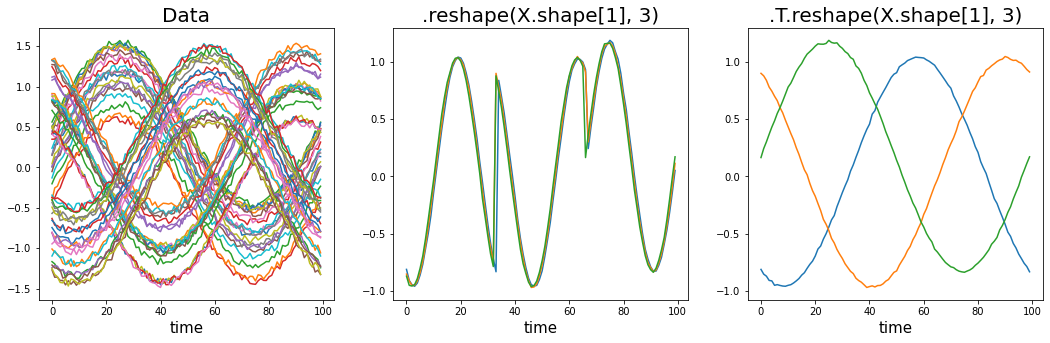

In [51]:
fig, axs = plt.subplots(1,3,figsize=(18,5))
axs[0].plot(X.T)
axs[1].plot(km.cluster_centers_.reshape(X.shape[1], n_cluster))
axs[2].plot(km.cluster_centers_.T.reshape(X.shape[1], n_cluster))
for i, k in enumerate(['Data', f'.reshape(X.shape[1], {n_cluster})', f'.T.reshape(X.shape[1], {n_cluster})']):
    axs[i].set_title(k, fontsize = 20)
    axs[i].set_xlabel('time', fontsize = 15)

In [103]:
print(f'Second plot Data Shape: {km.cluster_centers_.reshape(X.shape[1], n_cluster).shape}')
print(f'Third plot Data Shape: {km.cluster_centers_.T.reshape(X.shape[1], n_cluster).shape}')

Second plot Data Shape: (100, 3)
Third plot Data Shape: (100, 3)


In my opinion the second one is wrong because did not represent the input data and neither the mean of the series in the same cluster.

I suppose that we should use the right side option.

Let's see this in another way:

Input data shape: (60, 100)
Output centroid shape: (3, 100, 1)
Reformatted centroid shape: (3, 100)


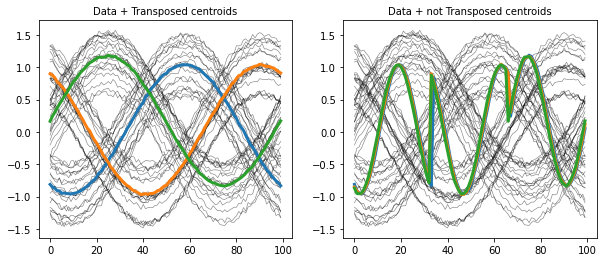

In [52]:
print(f'Input data shape: {X.shape}')
# Firt step: reformat the output.
print(f'Output centroid shape: {km.cluster_centers_.shape}')
centers = km.cluster_centers_[:,:,0] # Slicing to remove the last dimension 
print(f'Reformatted centroid shape: {centers.shape}')

fig, axs = plt.subplots(1,2,figsize=(10,4))
axs[0].plot(X.T, c='black', alpha=0.5, linewidth=0.6)
axs[0].set_title('Data + Transposed centroids', fontsize = 10)
axs[0].plot(centers.T, linewidth=3)

axs[1].plot(X.T, c='black', alpha=0.5, linewidth=0.6)
axs[1].set_title('Data + not Transposed centroids', fontsize = 10)
axs[1].plot(km.cluster_centers_.reshape(X.shape[1], n_cluster), linewidth=3)
plt.show()

#### Medoids

Let's find the medoids curve using the two different centers (left and right of previous plot).

First find the curve with minimum distance from the centroid of his cluster.

Minimum distance for Transposed case:
0.27
0.28
0.29

Minimum distance for the not Transposes case:
8.93
10.29
10.74


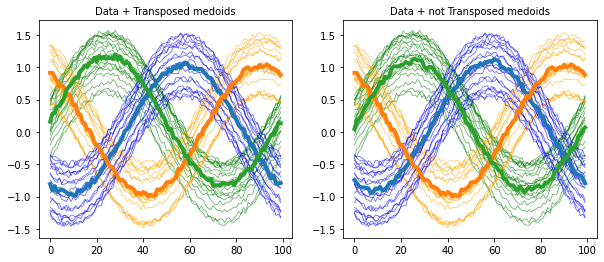

In [90]:
centers1 = km.cluster_centers_[:,:,0] # Left
centers2 = km.cluster_centers_.reshape(X.shape[1], n_cluster) # Right
labls = km.labels_ # Clusters labels
medoids1 = []
medoids2 = []

# Transposed case
print('Minimum distance for Transposed case:')
for l in np.unique(labls):
    dist = []
    inner_yy = yy[labls == l]
    for y in inner_yy:
        dist.append(euclidean(y, centers1[l])) # Evaluating distance 
    dist = np.array(dist)
    print(f'{dist[np.argsort(dist)[0]]:.2f}')
    medoids1.append(inner_yy[np.argsort(dist)[0]]) # Save only the closer curve to the centroids
medoids1 = np.array(medoids1)

# Not Transposed case
print('\nMinimum distance for the not Transposes case:')
for l in np.unique(labls):
    dist = []
    inner_yy = yy[labls == l]
    for y in inner_yy:
        dist.append(euclidean(y, centers2[:,l]))
    dist = np.array(dist)
    print(f'{dist[np.argsort(dist)[0]]:.2f}')
    medoids2.append(inner_yy[np.argsort(dist)[0]])
medoids2 = np.array(medoids2)


fig, axs = plt.subplots(1,2,figsize=(10,4))

# Only way to control the colors of the curve: plot them one at time in a loop
colors = {'0':'blue', '1':'orange', '2':'green'}
for i, x in enumerate(X):
    axs[0].plot(x, c=colors[str(labls[i])], alpha=0.6, linewidth=0.8)
    axs[1].plot(x, c=colors[str(labls[i])], alpha=0.6, linewidth=0.8)

    
axs[0].set_title('Data + Transposed medoids', fontsize = 10)
axs[0].plot(medoids1.T, linewidth=4)

axs[1].set_title('Data + not Transposed medoids', fontsize = 10)
axs[1].plot(medoids2.T, linewidth=4)
plt.show()

Both of the centroids seems to perform well, but the second one return distance of one order of magnitude higher than the first one... 

So lets try the same thing without searching in the clusters separately:

Minimum distances for Transposed case:
 - d = 0.27, Time series (first numbers): [-0.80706782 -0.90427904 -0.83825662 -0.92972275 -0.90293839]
 - d = 0.28, Time series (first numbers): [0.91402607 0.91256989 0.84779482 0.79163534 0.70964744]
 - d = 0.29, Time series (first numbers): [0.15825979 0.28204656 0.28644527 0.39158052 0.39938055]

Minimum distances for the not Transposes case:
 - d = 8.93, Time series (first numbers): [-0.74396921 -0.79369071 -0.84111071 -0.85981354 -0.85724284]
 - d = 8.90, Time series (first numbers): [-0.74396921 -0.79369071 -0.84111071 -0.85981354 -0.85724284]
 - d = 8.93, Time series (first numbers): [-0.74396921 -0.79369071 -0.84111071 -0.85981354 -0.85724284]


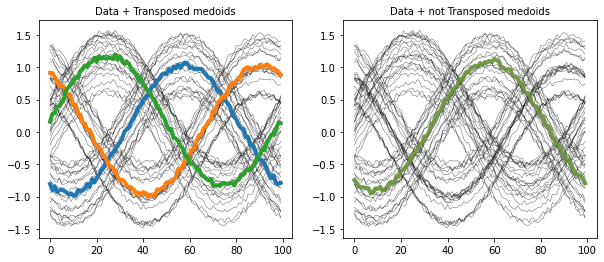

In [89]:
centers1 = km.cluster_centers_[:,:,0] # Left
centers2 = km.cluster_centers_.reshape(X.shape[1], n_cluster) # Right
labls = km.labels_
medoids1 = []
medoids2 = []

print('Minimum distances for Transposed case:')
for l in np.unique(labls):
    dist = []
    inner_yy = yy[labls == l]
    for y in yy:
        dist.append(euclidean(y, centers1[l]))
    dist = np.array(dist)
    print(f' - d = {dist[np.argsort(dist)[0]]:.2f}, Time series (first numbers): {yy[np.argsort(dist)[0]][:5]}')
    medoids1.append(yy[np.argsort(dist)[0]])
medoids1 = np.array(medoids1)

print('\nMinimum distances for the not Transposes case:')
for l in np.unique(labls):
    dist = []
    for y in yy:
        dist.append(euclidean(y, centers2[:,l]))
    dist = np.array(dist)
    print(f' - d = {dist[np.argsort(dist)[0]]:.2f}, Time series (first numbers): {yy[np.argsort(dist)[0]][:5]}')
    medoids2.append(yy[np.argsort(dist)[0]])
medoids2 = np.array(medoids2)


fig, axs = plt.subplots(1,2,figsize=(10,4))
axs[0].plot(X.T, c='black', alpha=0.5, linewidth=0.6)
axs[0].set_title('Data + Transposed medoids', fontsize = 10)
axs[0].plot(medoids1.T, linewidth=4)

axs[1].plot(X.T, c='black', alpha=0.5, linewidth=0.6)
axs[1].set_title('Data + not Transposed medoids', fontsize = 10)
axs[1].plot(medoids2.T, alpha= 0.5, linewidth=4)
plt.show()

As I suppose: the second method select always the same curve: the most central...

This because the second centroids just "confuse" the metric euclidean: the closer curve is intuitively the most central.